# Dataloader
**Code to load pre-tokenized data and build embeddings using pre-trained vectors.**

Please be sure that this directory is cloned under the directory for HW1. The structure of HW1 folder should be as followed.
- HW1
    - data
        - mnli_train.tsv
        - mnli_val.tsv
        - snli_train.tsv
        - snli_val.tsv
    - < name of this github repo >
        - < the current notebook >
    - wiki-news-300d-1M.vec

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import pickle as pkl
import datetime
import random
import numpy as np
import torch
from torch.utils.data import Dataset

In [2]:
import load_data

In [6]:
## Initialization included by Howard
import os

In [9]:
## Add this line to make the project portable
CURR_PATH = os.getcwd()

DATA_PATH = '/data/'
VEC_PATH = '/wiki-news-300d-1M.vec'

VOCAB_SIZE = 50000

### Tokenization

In [10]:
## Add current path to imnprove portability
snli_train = pd.read_csv(CURR_PATH + DATA_PATH + "snli_train.tsv", sep='\t')
snli_val = pd.read_csv(CURR_PATH + DATA_PATH + "snli_val.tsv", sep='\t')

In [11]:
# # Make directory /pickle/ if it doesn't already exist.
# import os
# os.mkdir(os.getcwd()+'/pickle/')

The current `50000_vectors.pkl`, `50000_id2token.pkl`, and `50000_token2id.pkl` is for `vocab size` of `50000`. The files can be downloaded from https://drive.google.com/open?id=1Fn49uTsw03KHZ6VsoG-eYwaPRYAwnqPe and should be saved under `os.getcwd()+'/pickle/'`. Need to re-run the block of code below for other `vocab size` options.

In [12]:
# print(datetime.datetime.now().strftime("%H:%M:%S"))
# train_data = load_data.prepare_data(snli_train)
# token2id, id2token, vectors = load_data.build_vocabulary(train_data, VEC_PATH, VOCAB_SIZE)
# pkl.dump(vectors, open('pickle/'+str(VOCAB_SIZE)+'_vectors.pkl', 'wb'))
# pkl.dump(token2id, open('pickle/'+str(VOCAB_SIZE)+'_token2id.pkl', 'wb'))
# pkl.dump(id2token, open('pickle/'+str(VOCAB_SIZE)+'_id2token.pkl', 'wb'))
# print(datetime.datetime.now().strftime("%H:%M:%S"))

In [13]:
train_data = load_data.prepare_data(snli_train)
val_data = load_data.prepare_data(snli_val)
vectors = pkl.load(open('pickle/'+str(VOCAB_SIZE)+'_vectors.pkl', 'rb'))
id2token = pkl.load(open('pickle/'+str(VOCAB_SIZE)+'_id2token.pkl', 'rb'))
token2id = pkl.load(open('pickle/'+str(VOCAB_SIZE)+'_token2id.pkl', 'rb'))

In [14]:
# double checking
print ("Train dataset size is {}".format(len(train_data)))
print ("Val dataset size is {}".format(len(val_data)))
print ("Total number of vocab built from train dataset is {}".format(len(set(id2token))))

Train dataset size is 100000
Val dataset size is 1000
Total number of vocab built from train dataset is 22059


In [15]:
# Lets check the dictionary by loading random token from it
random_token_id = random.randint(0, len(id2token)-1)
random_token = id2token[random_token_id]

print ("Token id {} ; token {}".format(random_token_id, id2token[random_token_id]))
print ("Token {}; token id {}".format(random_token, token2id[random_token]))

Token id 8677 ; token glide
Token glide; token id 8677


### Determine `MAX_SENTENCE_LENGTH`

In [23]:
train_data.head()

,sentence1,sentence2,label
0,"[A, young, girl, in, a, pink, shirt, sitting, ...","[A, young, girl, watching, the, sunset, over, ...",1
1,"[A, woman, is, smiling, while, the, man, next,...","[Two, people, are, next, to, each, other, .]",2
2,"[Across, the, river, ,, you, can, see, a, larg...","[The, large, building, is, full, of, apartment...",1
3,"[a, man, in, white, shorts, and, a, black, shi...","[A, man, is, riding, a, jetski, on, the, ocean...",0
4,"[Four, black, dogs, run, together, on, bright,...","[Four, dogs, are, preparing, to, be, launched,...",0


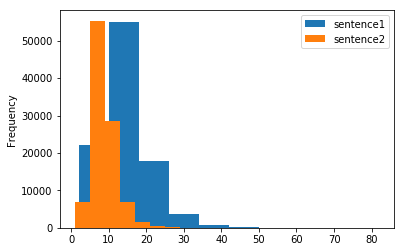

In [24]:
# plot sentence length to determine a good value for MAX_SENTENCE_LENGTH
train_data.sentence1.str.len().plot(kind='hist', legend=True);
train_data.sentence2.str.len().plot(kind='hist', legend=True);

Determined `MAX_SENTENCE_LENGTH = 30`. This variable is specified in `load_data.py`.

### token2index

In [27]:
indiced_train_data, train_target = load_data.token2index_dataset(train_data, token2id, 30)
indiced_val_data, val_target = load_data.token2index_dataset(val_data, token2id, 30)

### Pytorch DataLoader

In [28]:
BATCH_SIZE = 32
train_dataset = load_data.SNLIDataset(indiced_train_data, train_target)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=load_data.SNLI_collate_func,
                                           shuffle=True)

val_dataset = load_data.SNLIDataset(indiced_val_data, val_target)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=load_data.SNLI_collate_func,
                                           shuffle=True)

In [16]:
# check that the dataloader works
for i, (x1, x1_lengths, x2, x2_lengths, labels) in enumerate(train_loader):
    print(x1_lengths, x1.size())
    print(x2_lengths, x2.size())
    print(labels)
    break

tensor([ 7, 10, 12,  9,  9, 16,  7, 13, 18, 22, 30, 16, 10,  9,  6,  6, 10, 13,
        26, 11, 13,  9, 19, 10,  8, 10, 14, 20, 16, 10, 17, 19]) torch.Size([32, 30])
tensor([ 4,  8, 10,  4,  4,  7,  8, 10,  7,  9, 14, 13, 11,  8,  8,  8,  2,  7,
         8,  4,  9,  9, 11,  7,  4,  6, 11,  7,  8,  7, 10, 13]) torch.Size([32, 30])
tensor([1, 2, 0, 0, 2, 0, 0, 0, 2, 1, 1, 1, 0, 0, 1, 2, 0, 2, 2, 1, 1, 1, 2, 2,
        0, 2, 1, 2, 0, 1, 0, 0])


### nn.Embedding

In [17]:
# create weights matrix from pretrained vectors
weights_matrix = load_data.create_weights(vectors, id2token)
print(weights_matrix.size())

torch.Size([22059, 300])


**how to use the pretrained embedding in model**

In [18]:
emb_layer, num_embeddings, embedding_dim = load_data.create_emb_layer(weights_matrix)

print(emb_layer)

for x1, x1_lengths, x2, x2_lengths, labels in train_loader:
    print(emb_layer(x1).size())
    break

Embedding(22059, 300)
torch.Size([32, 30, 300])


**embedding layer dimension = (batch size x max sentence length x embedding dim)**

# Use MNLI dataset with the vocab built from SNLI
The code is pretty much the same with SNLI except for an additional filter on genre.

In [19]:
mnli_train = pd.read_csv(DATA_PATH + "mnli_train.tsv", sep='\t')
mnli_val = pd.read_csv(DATA_PATH + "mnli_val.tsv", sep='\t')

The key is to just use `vectors`, `id2token`, and `token2id` that was built from SNLI train set

In [20]:
mnli_train_data = load_data.prepare_data(mnli_train)
mnli_val_data = load_data.prepare_data(mnli_val)
vectors = pkl.load(open('pickle/'+str(VOCAB_SIZE)+'_vectors.pkl', 'rb'))
id2token = pkl.load(open('pickle/'+str(VOCAB_SIZE)+'_id2token.pkl', 'rb'))
token2id = pkl.load(open('pickle/'+str(VOCAB_SIZE)+'_token2id.pkl', 'rb'))

In [21]:
print ("Train dataset size is {}".format(len(mnli_train_data)))
print ("Val dataset size is {}".format(len(mnli_val_data)))
print ("Total number of vocab built from train dataset is {}".format(len(set(id2token))))

Train dataset size is 20000
Val dataset size is 5000
Total number of vocab built from train dataset is 22059


In [22]:
mnli_train_data.groupby('genre').count()

,sentence1,sentence2,label
genre,,,
fiction,3836,3836,3836
government,3883,3883,3883
slate,4026,4026,4026
telephone,4270,4270,4270
travel,3985,3985,3985


In [23]:
mnli_val_data.groupby('genre').count()

,sentence1,sentence2,label
genre,,,
fiction,995,995,995
government,1016,1016,1016
slate,1002,1002,1002
telephone,1005,1005,1005
travel,982,982,982


In [24]:
all_genre = mnli_train_data.genre.unique().tolist()
all_genre

['telephone', 'fiction', 'slate', 'government', 'travel']

Using `'telephone'` as an example here:

In [25]:
mnli_train_tel = mnli_train_data[mnli_train_data['genre'] == 'telephone']
mnli_val_tel = mnli_val_data[mnli_val_data['genre'] == 'telephone']

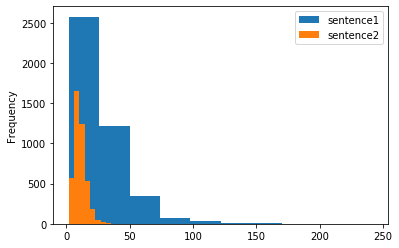

In [26]:
mnli_train_tel.sentence1.str.len().plot(kind='hist', legend=True);
mnli_train_tel.sentence2.str.len().plot(kind='hist', legend=True);

Here we would probably want to change the `MAX_SENTENCE_LENGTH` to about `50` before moving forward with building dataloaders.

In [27]:
indiced_train_data, train_target = load_data.token2index_dataset(mnli_train_tel, token2id)
indiced_val_data, val_target = load_data.token2index_dataset(mnli_val_tel, token2id)

In [28]:
BATCH_SIZE = 32
train_dataset = load_data.SNLIDataset(indiced_train_data, train_target)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=load_data.SNLI_collate_func,
                                           shuffle=True)

val_dataset = load_data.SNLIDataset(indiced_val_data, val_target)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=load_data.SNLI_collate_func,
                                           shuffle=True)

In [29]:
weights_matrix = load_data.create_weights(vectors, id2token)
print(weights_matrix.size())

torch.Size([22059, 300])


In [30]:
emb_layer, num_embeddings, embedding_dim = load_data.create_emb_layer(weights_matrix)

print(emb_layer)

for x1, x1_lengths, x2, x2_lengths, labels in train_loader:
    print(emb_layer(x1).size())
    break

Embedding(22059, 300)
torch.Size([32, 30, 300])
